INSTALLING PACKAGES

In [ ]:
!pip install transformers
!pip install fitz
!pip install spacy
!pip install PyMuPDF
!pip install torch
!pip install nlpaug
!pip install spacy-transformers
!pip install dataset
!pip install pdfplumber

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.8 MB/s eta 0:00:00


IMPORTING PACKAGES

In [ ]:
import os
import re
import random
import pickle
import fitz
import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
# Download NLTK stopwords
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


EXTRACT TEXT FROM PDF

In [ ]:
def extract_text_from_pdfs(pdf_paths):
    all_text = []
    for pdf_path in pdf_paths:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        all_text.append(text)
    return all_text

CREATING NER DATA USING REGEX PATTERN

In [ ]:
def create_ner_training_data(texts):
    training_data = []

    patterns = {
        'SUPERNOVA_NAME': re.compile(r'\bSN\d{4}[A-Za-z]*\b'),
        'SUPERNOVA_TYPE': re.compile(r'\bType [I|II][a-c|p|n|l|b]?\b'),
        'LUMINOSITY': re.compile(r'-?\d+\.\d+ mag'),
        'HOST_GALAXY': re.compile(r'NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|A\d+|PKS \d+'),
        'REDSHIFT': re.compile(r'z=\d+\.\d+'),
        'DISTANCE': re.compile(r'\d+\.\d+ Mpc')
    }

    for text in texts:
        entities = []
        for label, pattern in patterns.items():
            for match in pattern.finditer(text):
                start, end = match.span()
                entities.append((start, end, label))


        entities.sort(key=lambda x: x[0])
        training_data.append((text, {"entities": entities}))

    return training_data

TRAINING CUSTOM NER

In [ ]:
def train_custom_ner(train_data, iterations=30):
    nlp = spacy.blank("en")
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                for text, annotations in batch:
                    doc = nlp.make_doc(text)
                    example = Example.from_dict(doc, annotations)
                    nlp.update([example], drop=0.5, losses=losses)
            print(f"Losses at iteration {itn}: {losses}")

    return nlp

EXTRACTING INITIAL ANNOTATION USING REGEX PATTERN

In [ ]:
def initial_annotation(text):
    annotations = []

    patterns = {
        'SUPERNOVA_NAME': re.compile(r'\bSN\d{4}[A-Za-z]*\b'),
        'SUPERNOVA_TYPE': re.compile(r'\bType [I|II][a-c|p|n|l|b]?\b'),
        'LUMINOSITY': re.compile(r'-?\d+\.\d+ mag'),
        'HOST_GALAXY': re.compile(r'NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|A\d+|PKS \d+'),
        'REDSHIFT': re.compile(r'z=\d+\.\d+'),
        'DISTANCE': re.compile(r'\d+\.\d+ Mpc')
    }

    for label, pattern in patterns.items():
        for match in pattern.finditer(text):
            annotations.append((match.group(), label))

    return annotations

USING CUSTOM NER EXTRACTING MORE ANNOTATIONS

In [ ]:
def ner_annotation(text):
    custom_ner_model = spacy.load("./custom_supernova_ner")
    doc = custom_ner_model(text)

    all_results = []
    for ent in doc.ents:
        label = ent.label_
        word = ent.text

        if validate_entity(word, label):
            all_results.append((word, label))

    return all_results

VALIDATING THE ANNOTATIONS

In [ ]:
def validate_entity(entity, label):
    supernova_name_pattern = re.compile(r'^SN\d{4}[A-Za-z]*$')
    type_pattern = re.compile(r'^Type [I|II][a-c|p|n|l|b]?$')
    luminosity_pattern = re.compile(r'^-?\d+\.\d+ mag$')
    host_galaxy_pattern = re.compile(r'^(NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|PKS \d+)$')
    redshift_pattern = re.compile(r'^z=\d+\.\d+$')
    distance_pattern = re.compile(r'^\d+\.\d+ Mpc$')

    if label == "SUPERNOVA_NAME" and supernova_name_pattern.match(entity):
        return True
    elif label == "SUPERNOVA_TYPE" and type_pattern.match(entity):
        return True
    elif label == "LUMINOSITY" and luminosity_pattern.match(entity):
        return True
    elif label == "HOST_GALAXY" and host_galaxy_pattern.match(entity):
        return True
    elif label == "REDSHIFT" and redshift_pattern.match(entity):
        return True
    elif label == "DISTANCE" and distance_pattern.match(entity):
        return True

    return False

COMBINING ALL ANNOTATIONS

In [ ]:
def combined_annotation(text):
    if not text.strip():
        return []

    rule_based_anns = initial_annotation(text)
    ner_anns = ner_annotation(text)

    combined_anns = list(set(rule_based_anns + ner_anns))

    valid_annotations = [ann for ann in combined_anns if validate_entity(ann[0], ann[1])]

    return valid_annotations

GATHERING ALL ANNOTAIONS

In [ ]:
def gather_valid_annotations(texts):
    all_annotations = []
    for text in texts:
        annotations = combined_annotation(text)
        all_annotations.extend(annotations)
    return all_annotations

EXTRACTING ANNOTATION FROM 20 PDFs

In [ ]:
import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
import random
# Main execution
pdf_paths = ['/content/sample_data/Supernovae_dataset/0303428v1.pdf',
             '/content/sample_data/Supernovae_dataset/0601261v1.pdf',
             '/content/sample_data/Supernovae_dataset/0611295v2.pdf',
             '/content/sample_data/Supernovae_dataset/0612072v1.pdf',
             '/content/sample_data/Supernovae_dataset/0706.4088v1.pdf',
             '/content/sample_data/Supernovae_dataset/0708.2749v1.pdf',
             '/content/sample_data/Supernovae_dataset/0801.3297v3.pdf',
             '/content/sample_data/Supernovae_dataset/0905.4125v1.pdf',
             '/content/sample_data/Supernovae_dataset/0907.4524v1.pdf',
             '/content/sample_data/Supernovae_dataset/0908.4277v1.pdf',
             '/content/sample_data/Supernovae_dataset/0910.5597v2.pdf',
             '/content/sample_data/Supernovae_dataset/1211.1378v1.pdf',
             '/content/sample_data/Supernovae_dataset/1803.01875v2.pdf',
             '/content/sample_data/Supernovae_dataset/1805.03207v1.pdf',
             '/content/sample_data/Supernovae_dataset/2103.05230v1.pdf',
             '/content/sample_data/Supernovae_dataset/2105.00665v2.pdf',
             '/content/sample_data/Supernovae_dataset/2312.04621v2.pdf',
             '/content/sample_data/Supernovae_dataset/2407.03721v1.pdf',
             '/content/sample_data/Supernovae_dataset/2408.06287v1.pdf',
             '/content/sample_data/Supernovae_dataset/9805201v1.pdf'
             ]

texts = extract_text_from_pdfs(pdf_paths)
training_data = create_ner_training_data(texts)
custom_ner_model = train_custom_ner(training_data)
custom_ner_model.to_disk("./custom_supernova_ner")

extracted_texts = extract_text_from_pdfs(pdf_paths)
valid_annotations = gather_valid_annotations(extracted_texts)

print(f"Number of valid annotations: {len(valid_annotations)}")
print("Sample annotations:")
for ann in valid_annotations[:10]:
    print(ann)

Losses at iteration 0: {'ner': 195340.07953623764}
Losses at iteration 1: {'ner': 1542.7648983745084}
Losses at iteration 2: {'ner': 1288.2987859952802}
Losses at iteration 3: {'ner': 1096.2300816335332}
Losses at iteration 4: {'ner': 745.1650337502306}
Losses at iteration 5: {'ner': 927.0645113492918}
Losses at iteration 6: {'ner': 458.97681723409374}
Losses at iteration 7: {'ner': 319.5011753948648}
Losses at iteration 8: {'ner': 279.21756343304304}
Losses at iteration 9: {'ner': 239.73742267268207}
Losses at iteration 10: {'ner': 220.9450231462456}
Losses at iteration 11: {'ner': 190.39777304984216}
Losses at iteration 12: {'ner': 202.52082317388826}
Losses at iteration 13: {'ner': 181.78355107873324}
Losses at iteration 14: {'ner': 170.36774385911815}
Losses at iteration 15: {'ner': 213.92457998331193}
Losses at iteration 16: {'ner': 99.09850551649599}
Losses at iteration 17: {'ner': 133.09497302021708}
Losses at iteration 18: {'ner': 84.82826783170454}
Losses at iteration 19: {'ne

VISUALISING ALL ANNOTATIONS

In [ ]:
print(f"Number of valid annotations: {len(valid_annotations)}")
print("Sample annotations:")
for ann in valid_annotations[0:300]:
    print(ann)

Number of valid annotations: 302
Sample annotations:
('SN1989B', 'SUPERNOVA_NAME')
('SN1991bg', 'SUPERNOVA_NAME')
('0.2 mag', 'LUMINOSITY')
('SN1991T', 'SUPERNOVA_NAME')
('0.25 mag', 'LUMINOSITY')
('SN1998eq', 'SUPERNOVA_NAME')
('22.1 mag', 'LUMINOSITY')
('SN1981B', 'SUPERNOVA_NAME')
('SN1998bu', 'SUPERNOVA_NAME')
('SN1992bi', 'SUPERNOVA_NAME')
('0.12 mag', 'LUMINOSITY')
('SN1972E', 'SUPERNOVA_NAME')
('0.02 mag', 'LUMINOSITY')
('0.04 mag', 'LUMINOSITY')
('SN1987A', 'SUPERNOVA_NAME')
('SN1974G', 'SUPERNOVA_NAME')
('SN1895B', 'SUPERNOVA_NAME')
('0.6 mag', 'LUMINOSITY')
('0.7 mag', 'LUMINOSITY')
('0.06 mag', 'LUMINOSITY')
('Type Ia', 'SUPERNOVA_TYPE')
('SN1986G', 'SUPERNOVA_NAME')
('SN1999em', 'SUPERNOVA_NAME')
('SN1960F', 'SUPERNOVA_NAME')
('0.01 mag', 'LUMINOSITY')
('SN1937C', 'SUPERNOVA_NAME')
('SN1990N', 'SUPERNOVA_NAME')
('SN1999by', 'SUPERNOVA_NAME')
('19.5 mag', 'LUMINOSITY')
('Type Ia', 'SUPERNOVA_TYPE')
('Type I', 'SUPERNOVA_TYPE')
('0.27 mag', 'LUMINOSITY')
('1.6 mag', 'LUMINOSI

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from transformers import BertTokenizer, TFBertForTokenClassification

PREPARING DATA FOR THE MODELS BY ENCODING AND CHANGING THE ANNOTATIONS TO A DATAFRAME

In [ ]:
def prepare_data(annotations):
    # Convert annotations to DataFrame
    df = pd.DataFrame(annotations, columns=['word', 'label'])

    # Create label encoding
    label_encoding = {label: i for i, label in enumerate(df['label'].unique())}
    df['label_id'] = df['label'].map(label_encoding)

    return df, label_encoding

PREPARING DATA FOR BI-LSTM

In [ ]:
def prepare_lstm_data(df):
    # Tokenize words
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(df['word'])
    word_index = tokenizer.word_index

    # Convert words to sequences
    X = tokenizer.texts_to_sequences(df['word'])
    X = pad_sequences(X, padding='post', maxlen=1)  # Each word is a separate sample

    # Prepare labels
    y = to_categorical(df['label_id'])

    return X, y, word_index

PREPARING DATA FOR BERT

In [ ]:
def prepare_bert_data(df, label_encoding):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


    input_ids = []
    labels = []

    for _, row in df.iterrows():
        word_tokens = tokenizer.encode(row['word'], add_special_tokens=False)
        input_ids.extend(word_tokens)
        labels.extend([row['label_id']] * len(word_tokens))


    max_length = 128
    input_ids = input_ids[:max_length] + [0] * (max_length - len(input_ids))
    labels = labels[:max_length] + [-100] * (max_length - len(labels))

    attention_mask = [1 if id != 0 else 0 for id in input_ids]

    return {
        'input_ids': tf.constant([input_ids]),
        'attention_mask': tf.constant([attention_mask])
    }, tf.constant([labels])

CREATING LSTM MODEL

In [ ]:
def create_lstm_model(vocab_size, embedding_dim, input_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Bidirectional(LSTM(64)),
        Dropout(0.2),
        Dense(num_classes, activation="softmax")
    ])
    return model

TRAINING LSTM MODEL

In [ ]:
def train_evaluate_lstm(X, y, vocab_size, num_classes):
    model = create_lstm_model(vocab_size, 100, X.shape[1], num_classes)

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(X, y, batch_size=32, epochs=50, validation_split=0.2, verbose=1)

    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y, axis=-1)

    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    return model, history, report, accuracy

TRAINING BERT MODEL

In [ ]:
def train_evaluate_bert(encodings, labels, label_encoding):
    model = TFBertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoding))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    history = model.fit(encodings, labels, epochs=10, batch_size=16, verbose=1)

    predictions = model.predict(encodings)
    pred_labels = np.argmax(predictions.logits, axis=-1)

    true_labels = labels.numpy()[0]
    pred_labels = pred_labels[0]


    mask = true_labels != -100
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]

    report = classification_report(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)

    return history, report, accuracy

EVALUATING METRICS FOR BOTH MODELS

In [ ]:
def visualize_metrics(lstm_history, bert_history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
    plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
    plt.plot(bert_history.history['accuracy'], label='BERT Training Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
    plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
    plt.plot(bert_history.history['loss'], label='BERT Training Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

EXTRACTING ENTITIES FROM NEW PDF FOR LSTM

In [ ]:
def extract_entities_lstm(text, model, tokenizer, label_encoding):
    words = text.split()
    X = tokenizer.texts_to_sequences(words)
    X = pad_sequences(X, padding='post', maxlen=1)
    predictions = model.predict(X)
    pred_labels = np.argmax(predictions, axis=-1)

    entities = []
    current_entity = None
    reverse_label_encoding = {v: k for k, v in label_encoding.items()}

    for word, label_id in zip(words, pred_labels):
        if label_id != 0:
            label = reverse_label_encoding[label_id]
            if current_entity is None:
                current_entity = {'text': word, 'label': label}
            elif label == current_entity['label']:
                current_entity['text'] += ' ' + word
            else:
                entities.append(current_entity)
                current_entity = {'text': word, 'label': label}
        elif current_entity is not None:
            entities.append(current_entity)
            current_entity = None

    if current_entity is not None:
        entities.append(current_entity)

    return entities

EXTRACTING ENTITIES FROM NEW PDF FOR BERT

In [ ]:
def extract_entities_bert(text, model, tokenizer, label_encoding):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(inputs)
    predictions = tf.argmax(outputs.logits, axis=-1)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    entities = []
    current_entity = None
    reverse_label_encoding = {v: k for k, v in label_encoding.items()}

    for token, label_id in zip(tokens, predictions[0]):
        if token.startswith("##"):
            if current_entity:
                current_entity['text'] += token[2:]
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None

            if label_id != 0:
                label = reverse_label_encoding[label_id.numpy()]
                current_entity = {'text': token, 'label': label}

    if current_entity:
        entities.append(current_entity)

    return entities

MAIN EXECUTION

In [ ]:
df, label_encoding = prepare_data(valid_annotations)

In [ ]:
# LSTM
X, y, word_index = prepare_lstm_data(df)
lstm_model, lstm_history, lstm_report, lstm_accuracy = train_evaluate_lstm(X, y, len(word_index) + 1, len(label_encoding))


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5613 - loss: 1.7668 - val_accuracy: 0.6885 - val_loss: 1.6764
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6405 - loss: 1.6435 - val_accuracy: 0.6885 - val_loss: 1.4559
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6682 - loss: 1.4096 - val_accuracy: 0.7213 - val_loss: 1.0552
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6945 - loss: 1.0257 - val_accuracy: 0.7213 - val_loss: 0.6781
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7487 - loss: 0.7127 - val_accuracy: 0.7213 - val_loss: 0.5806
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8830 - loss: 0.6208 - val_accuracy: 0.7213 - val_loss: 0.5675
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8986 - loss: 0.7068 - val_accuracy: 0.7213 - val_loss: 0.5624
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8961 - loss: 0.6890 - val_accuracy: 0.7541 - val_loss: 0.5572
Epoch

In [ ]:
# BERT
encodings, labels = prepare_bert_data(df, label_encoding)
bert_history, bert_report, bert_accuracy = train_evaluate_bert(encodings, labels, label_encoding)


All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
1/1 [==============================] - 36s 36s/step - loss: 1.7218 - accuracy: 0.2734
Epoch 2/10
1/1 [==============================] - 0s 100ms/step - loss: 1.1555 - accuracy: 0.6719
Epoch 3/10
1/1 [==============================] - 0s 99ms/step - loss: 2.8221 - accuracy: 0.3125
Epoch 4/10
1/1 [==============================] - 0s 77ms/step - loss: 1.6676 - accuracy: 0.6719
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.8461 - accuracy: 0.6719
Epoch 6/10
1/1 [==============================] - 0s 72ms/step - loss: 0.9610 - accuracy: 0.3125
Epoch 7/10
1/1 [==============================] - 0s 69ms/step - loss: 0.8065 - accuracy: 0.4453
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 1.0352 - accuracy: 0.6719
Epoch 9/10
1/1 [==============================] - 0s 71ms/step - loss: 1.2765 - accuracy: 0.6719
Epoch 10/10
1/1 [==============================] - 0s 74ms/step - loss: 1.7271 - accuracy: 0.3125


1/1 [==============================] - 4s 4s/step


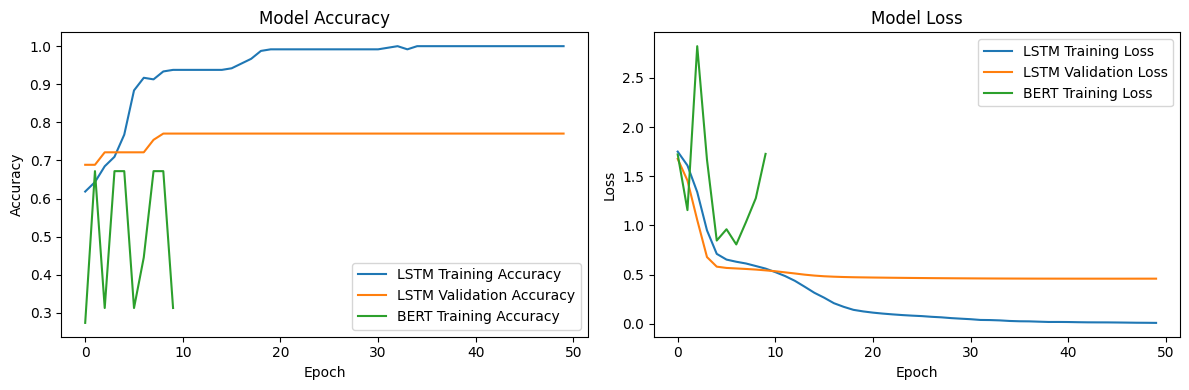

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        57
           1       1.00      1.00      1.00       191
           2       1.00      1.00      1.00        25
           3       1.00      0.56      0.72        16
           4       1.00      1.00      1.00         4
           5       1.00      0.22      0.36         9

    accuracy                           0.95       302
   macro avg       0.97      0.80      0.83       302
weighted avg       0.96      0.95      0.95       302

LSTM Accuracy: 0.9536423841059603

BERT Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        86
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00         2

    accuracy                           0.67       128
   macro avg       0.22      0.33      0.27       128
weighted avg       0.45      0.67      0

In [ ]:
# Visualize and comparing results
visualize_metrics(lstm_history, bert_history)

print("LSTM Classification Report:")
print(lstm_report)
print(f"LSTM Accuracy: {lstm_accuracy}")

print("\nBERT Classification Report:")
print(bert_report)
print(f"BERT Accuracy: {bert_accuracy}")

In [ ]:
# Extracting entities from new PDF
pdf_path = '/content/Supernovae.pdf'
new_text = extract_text_from_pdf(pdf_path)

# Extract entities using trained Bi-LSTM
lstm_entities = extract_entities_lstm(new_text, lstm_model, lstm_tokenizer, label_encoding)

print("\nLSTM Extracted Entities from new PDF:")
for entity in lstm_entities:
    print(f"{entity['label']}: {entity['text']}")


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

LSTM Extracted Entities from new PDF:
SUPERNOVA_TYPE: Ia
REDSHIFT: Alves,6
REDSHIFT: Andrade-Oliveira,6
SUPERNOVA_TYPE: I.
REDSHIFT: Huterer,6
REDSHIFT: Schubnell,6
SUPERNOVA_TYPE: I.
REDSHIFT: Tarle,6
REDSHIFT: Weaverdyck,6,
SUPERNOVA_TYPE: i
HOST_GALAXY: 300
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia)
SUPERNOVA_TYPE: Ia,
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia),
SUPERNOVA_TYPE: i,
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
REDSHIFT: 6.
SUPERNOVA_TYPE: i,
SUPERNOVA_TYPE: i,
LUMINOSITY: mag
LUMINOSITY: mag
REDSHIFT: 6
SUPERNOVA_TYPE: Ia,
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: Ia.
SUPERNOVA_TYPE: Ia
SUPERNOVA_TYPE: µobs,i
SUPERNOVA_TYPE: −∆µbias,i,
SUPERNOVA_TYPE: Ia)
SUPERNOVA_TYPE: Ia)
REDSHIFT: 0.6
SUPERNOVA_TYPE: Ia;
SUPERNOVA_TYPE: i
SUPERNOVA_TYPE: ∆µbias,i
SUPERNOVA_TYPE: ∆µbias,i
SUPERNOVA_TYPE: Ia
LUMINOSITY: mag
SUPERNOVA_TYPE: Ia
REDSHIFT: 6
SUPERNOVA_TYPE:

In [ ]:
# Extract entities using fine tuned BERT
bert_model = bert_history.model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_entities = extract_entities_bert(new_text, bert_model, bert_tokenizer, label_encoding)

print("\nBERT Extracted Entities from new PDF:")
for entity in bert_entities:
    print(f"{entity['label']}: {entity['text']}")


BERT Extracted Entities from new PDF:
